In [1]:
#!pip install tensorly

In [2]:
from tensorly.decomposition import tensor_train
import numpy as np
import torch
def initialize_mps(N, bond_dim=10, init_type='linear'):
    x = torch.linspace(0, 1, 2**N)  # Use torch instead of np
    u0 = x if init_type == 'linear' else torch.sin(torch.pi * x)
    u_tensor = u0.reshape([2]*N)  # Reshape using torch
    return tl.decomposition.tensor_train(u_tensor, rank=bond_dim)

In [3]:
from scipy.linalg import toeplitz
def finite_diff_operator(N):
    stencil = np.array([-1, 0, 1]) / 2  # central difference
    kernel = toeplitz(stencil, np.zeros(N))
    return kernel

In [4]:
import tensorly as tl
from tensorly.tt_matrix import tt_matrix_to_tensor
tl.set_backend('pytorch')  # or 'tensorflow'
def evolve_mps(u_mps, dt, dx, nu, N):

    # Convert MPS to PyTorch tensor
    u_tensor = tl.tt_to_tensor(u_mps).reshape(2**N)

    # Convert to NumPy array for gradient calculations
    u_np = u_tensor.detach().cpu().numpy()

    # Compute gradients
    du_dx = np.gradient(u_np, dx)
    d2u_dx2 = np.gradient(du_dx, dx)

    # Time evolution
    u_next = u_np - dt * u_np * du_dx + nu * dt * d2u_dx2

    # Sanitize and normalize
    u_next = np.nan_to_num(u_next, nan=0.0, posinf=1e6, neginf=-1e6)
    u_next /= np.max(np.abs(u_next)) + 1e-12

    # Convert back to PyTorch tensor
    u_tensor = torch.tensor(u_next.reshape([2]*N), dtype=torch.float32)

    # Return updated MPS
    return tl.decomposition.tensor_train(u_tensor, rank=10)


In [6]:
def sample_pixels(u_mps, num_samples=100):
    import tensorly as tl
    import numpy as np

    # Convert MPS to PyTorch tensor and then to NumPy
    u_tensor = tl.tt_to_tensor(u_mps).reshape(-1)
    u_np = u_tensor.detach().cpu().numpy()

    # Sanitize values
    u_np = np.nan_to_num(u_np, nan=0.0, posinf=0.0, neginf=0.0)

    # Compute probability distribution
    prob = u_np**2
    total = np.sum(prob)

    # Handle edge case: all zeros
    if total == 0 or np.isnan(total) or np.isinf(total):
        prob = np.ones_like(prob) / len(prob)
    else:
        prob /= total  # Normalize safely

    # Final check
    prob = prob / np.sum(prob)  # Ensure exact normalization

    # Sample indices
    indices = np.random.choice(len(u_np), size=num_samples, p=prob)
    return indices, u_np[indices]

In [7]:
def enforce_dirichlet_direct(mps, u_left, u_right):
    # Modify only boundary slices, not the whole tensor

    # First site tensor
    core0 = mps.factors[0].clone()  # shape: [1, phys_dim, bond_dim]
    core0[0, 0, :] = u_left         # Assuming index 0 is x = 0
    mps.factors[0] = core0

    # Last site tensor
    coreN = mps.factors[-1].clone()  # shape: [bond_dim, phys_dim, 1]
    coreN[:, 0, 0] = u_right         # Assuming index 0 is x = 1
    mps.factors[-1] = coreN

    return mps

In [8]:
def sample_pixels_quantum(mps, num_samples=100):
    import torch

    N = len(mps.factors)
    samples = []

    for _ in range(num_samples):
        idx_bits = []

        # Start with a trivial boundary contraction
        left_env = torch.ones(1, 1)  # initial left environment

        for n in range(N):
            core = mps.factors[n]  # shape: [Dl, phys_dim, Dr]
            probs = []

            # Compute marginal for each bit value (0 or 1)
            for bit_val in range(core.shape[1]):
                slice_n = core[:, bit_val, :]  # tensor slice for phys_idx = bit_val
                temp = left_env @ slice_n  # contract with left environment
                probs.append(torch.norm(temp)**2)

            # Normalize to get probabilities
            probs = torch.tensor(probs)
            probs += 1e-12  # avoid zero
            probs = probs / probs.sum()

            # Sample bit value (0 or 1)
            sampled_bit = torch.multinomial(probs, 1).item()
            idx_bits.append(sampled_bit)

            # Update environment for next site
            left_env = left_env @ core[:, sampled_bit, :]

        # Convert bit list to flat index
        idx = sum([b << (N - 1 - i) for i, b in enumerate(idx_bits)])
        samples.append(idx)

    return samples

In [9]:
import matplotlib.pyplot as plt
def plot_solution(u_mps, N):
    u = tl.tt_to_tensor(u_mps).reshape(2**N)
    x = np.linspace(0, 1, 2**N)
    plt.plot(x, u)
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('1D Burgers’ Equation Solution via MPS')
    plt.grid()
    plt.show()

In [10]:
def truncate_mps(mps, rank):
        full_tensor = tl.tt_to_tensor(mps)
        truncated = tl.decomposition.tensor_train(full_tensor, rank=rank)
        return truncated

Initializing velocity field...
Evolving for 1000 steps...
Simulation complete in 5.22 seconds
Sampling solution points...
Sampled indices and values:
x = 0.5039, u = 0.5072
x = 0.4961, u = 1.4178
x = 0.0039, u = 0.7186
x = 0.4961, u = 1.4178
x = 0.4961, u = 1.4178
x = 0.9961, u = 1.0000
x = 0.4961, u = 1.4178
x = 0.4883, u = 0.5079
x = 0.5039, u = 0.5072
x = 0.4961, u = 1.4178
x = 0.9961, u = 1.0000
x = 0.0039, u = 0.7186
x = 0.4961, u = 1.4178
x = 0.4883, u = 0.5079
x = 0.5039, u = 0.5072
x = 0.9961, u = 1.0000
x = 0.0039, u = 0.7186
x = 0.9961, u = 1.0000
x = 0.4961, u = 1.4178
x = 0.9961, u = 1.0000
x = 0.4961, u = 1.4178
x = 0.4961, u = 1.4178
x = 0.9961, u = 1.0000
x = 0.4961, u = 1.4178
x = 0.4961, u = 1.4178
x = 0.4961, u = 1.4178
x = 0.4961, u = 1.4178
x = 0.0039, u = 0.7186
x = 0.4961, u = 1.4178
x = 0.9961, u = 1.0000
x = 0.9805, u = 0.1280
x = 0.4961, u = 1.4178
x = 0.4961, u = 1.4178
x = 0.4961, u = 1.4178
x = 0.9883, u = 0.3578
x = 0.4961, u = 1.4178
x = 0.4961, u = 1.4178

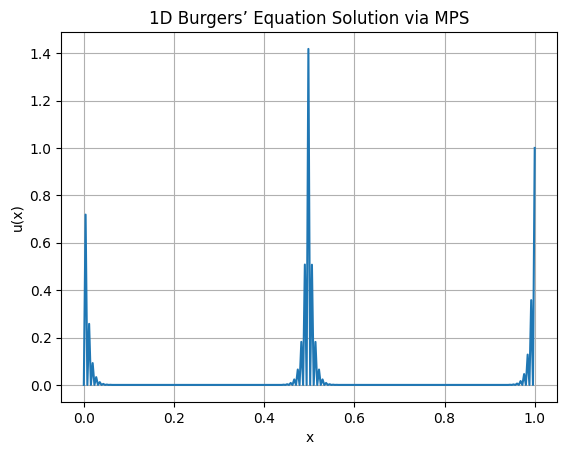

In [11]:
from time import time
def main():

    # Simulation parameters
    N = 8                    # Number of bits => mesh size = 2^N
    dx = 1.0 / (2**N)        # Spatial resolution
    dt = 0.001               # Time step
    T = 1.0                  # Total simulation time
    nu = 0.01                # Viscosity
    steps = int(T / dt)      # Number of steps

    # Initialize MPS field
    print("Initializing velocity field...")
    u_mps = initialize_mps(N, bond_dim=10, init_type='sinusoidal')

    # Time evolution
    print(f"Evolving for {steps} steps...")
    t_start = time()
    for _ in range(steps):
        u_mps = evolve_mps(u_mps, dt, dx, nu, N)
        u_mps = enforce_dirichlet_direct(u_mps, 1.0, 0.0)
        u_mps = truncate_mps(u_mps, rank=10)
    print(f"Simulation complete in {time() - t_start:.2f} seconds")

    # Sampling points
    print("Sampling solution points...")
    indices, sampled_values = sample_pixels(u_mps, num_samples=50)
    print("Sampled indices and values:")
    for idx, val in zip(indices, sampled_values):
        print(f"x = {idx * dx:.4f}, u = {val:.4f}")

    # Plotting
    print("Plotting final solution...")
    plot_solution(u_mps, N)


# Execute
if __name__ == "__main__":
    main()